In [1]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-
'''
    python ==> 비주얼컴퓨팅, 프로젝트4 얼굴 사진 55x40 데이터를 700장 사용해 LBP 연산을 수행한 후 Deeper NN에 넣어본 코드

'''
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.misc
import scipy.io
import random
import cv2


In [2]:
#-----------------------------------------------------------------
# train
train_images = []
tlabels = []

# train Image 데이터 700장을 불러온다
for num in range(1,701):
    train_images.append(scipy.misc.imread('D:\\edward\\visualComputing_faceDetection\\train_image\\train_'+ str(num)+'.bmp'))

# train Label 데이터를 불러온다
with open("D:\\edward\\visualComputing_faceDetection\\train_label.txt") as f:
    line = [line.rstrip() for line in f]
    tlabels.append(line)

# Image 데이터와 Label 데이터를 numpy 데이터로 수정한다
train_images = np.array(train_images)
# LBP 연산을 위해 train_images2 선언해준다
train_images2 = np.array(train_images)
train_images = train_images.reshape(700, 2200, )


tlabels = np.array(tlabels)     # tlabels = (1,700)
tlabels = tlabels.reshape(700,1)

# train Label 데이터를 [1 x 100] 의 행렬로 표현한다
#           예를 들어 3이면 [0,0,1,0,.....,0] 과 같이 설정한다
train_labels  = np.array(np.zeros(70000).reshape(700,100))
for num in range(0,700):
    train_labels[num][int(tlabels[num][0]) - 1] = 1



#-----------------------------------------------------------------
# test
test_images = []
testlabels = []


# test Image 데이터 700장을 불러온다
for num in range(1,701):
    test_images.append(scipy.misc.imread('D:\\edward\\visualComputing_faceDetection\\test_image\\test_'+ str(num)+'.bmp'))


# test Label 데이터를 불러온다
with open("D:\\edward\\visualComputing_faceDetection\\test_label.txt") as f:
    line = [line.rstrip() for line in f]
    testlabels.append(line)

# Image 데이터와 Label 데이터를 numpy 데이터로 수정한다
test_images = np.array(test_images)
# LBP 연산을 위해 test_images2 선언해준다
test_images2 = np.array(test_images)
test_images = test_images.reshape(700, 2200, )

testlabels = np.array(testlabels)     # tlabels = (1,700)
testlabels = testlabels.reshape(700,1)

# train Label 데이터를 [1 x 100] 의 행렬로 표현한다
#           예를 들어 3이면 [0,0,1,0,.....,0] 과 같이 설정한다
test_labels  = np.array(np.zeros(70000).reshape(700,100))
for num in range(0,700):
    test_labels[num][int(testlabels[num][0]) - 1] = 1


# 중요! Image 데이터들은 0~255 사이의 값이므로 255로 나눠주면서 정규화를 한다. 학습이 매우 잘된다
train_images = train_images / 255.
test_images =  test_images / 255.


#-----------------------------------------------------------------
# LBP izing

# 해당 사진 데이터의 크기를 받아온 후 lbp_img를 설정한다
num_img, rows, cols = train_images2.shape

newrows = int((rows-1)/2)
newcols = int((cols-1)/2)

# 트레이닝용 변수 선언
lbp_img = np.array(np.zeros(700 * newcols * newrows).reshape(700, newrows, newcols))

# 테스트용 변수 선언
lbp_img_test = lbp_img

# 한 점으로부터 2x2의 픽셀데이터를 반환하는 함수 
def neighborPixels(img, x, y):
    npixels = []

    npixels.append(img[x-1, y-1])
    npixels.append(img[x, y-1])
    npixels.append(img[x+1, y-1])
    npixels.append(img[x-1, y])
    npixels.append(img[x+1, y])
    npixels.append(img[x-1, y+1])
    npixels.append(img[x, y+1])
    npixels.append(img[x+1, y+1])

    return np.array(npixels)


# 중앙 center 점보다 neighbor_p 값이 크면 1을, 아니면 0을 반환하는 함수
def thresholded(center, neighbor_p):
    out = []
    for a in neighbor_p:
        if a > center:
            out.append(1)
        else:
            out.append(0)

    return out


# LBP 메인 알고리즘
for x in range(1, rows-1, 2):
    for y in range(1, cols -1, 2):
        for i in range(0, num_img - 1):
            center = train_images2[i][x,y]   # 중앙 픽셀값을 받아온다
            neighbor_p = neighborPixels(train_images2[i], x, y)  # 주변 점들의 값을 받아온다
            values = thresholded(center, neighbor_p) # center 점보다 주변값이 크면 1 아니면 0 을 반환한다

            weights = [1,2,4,8,16,32,64,128]
            res = 0

            for a in range(0, len(values)):
                res += weights[a] + values[a]
                lbp_img[i].itemset((x//2, y//2), res)


# 데이터를 정규화시킨다
lbp_img= lbp_img.reshape(700, 513)

# LBP의 결과값이 전부 255보다 크므로 255를 빼서 데이터를 0 ~ 8 사이로 놓는다
for i in range(0, num_img - 1):
    for j in range(0, 513):
            lbp_img[i][j] -= 255.

# 데이터를 0 ~ 1 로 놓기 위해 8로 나눠준다
lbp_img = lbp_img / 8.


# Test용 LBP 연산도 똑같이 한다
# LBP 메인 알고리즘
for x in range(1, rows-1, 2):
    for y in range(1, cols -1, 2):
        for i in range(0, num_img - 1):
            center = test_images2[i][x,y]   # 중앙 픽셀값을 받아온다
            neighbor_p = neighborPixels(test_images2[i], x, y)  # 주변 점들의 값을 받아온다
            values = thresholded(center, neighbor_p) # center 점보다 주변값이 크면 1 아니면 0 을 반환한다

            weights = [1,2,4,8,16,32,64,128]
            res = 0

            for a in range(0, len(values)):
                res += weights[a] + values[a]
                lbp_img_test[i].itemset((x//2, y//2), res)


# 데이터를 정규화시킨다
lbp_img_test= lbp_img_test.reshape(700, 513)

# LBP의 결과값이 전부 255보다 크므로 255를 빼서 데이터를 0 ~ 8 사이로 놓는다
for i in range(0, num_img - 1):
    for j in range(0, 513):
            lbp_img_test[i][j] -= 255.

# 데이터를 0 ~ 1 로 놓기 위해 8로 나눠준다
lbp_img_test = lbp_img_test / 8.



In [3]:
#-----------------------------------------------------------------

_num_examples = 700   # 데이터 갯수
_index_in_epoch = 0   # epoch
_images = lbp_img  # Image 변수 
_labels = train_labels  # Label 변수
_epochs_completed = 0   

# batch 연산을 수행하는 함수
# 호출될 때마다 랜덤으로 batch_size의 (Image, Label) 데이터를 반환한다
def next_batch(batch_size):
    """Return the next `batch_size` examples from this data set."""
    global _index_in_epoch
    global _images
    global _labels
    global _epochs_completed

    start = _index_in_epoch
    _index_in_epoch += batch_size

    if _index_in_epoch > _num_examples:
      # Finished epoch
      _epochs_completed += 1

      # Shuffle the data
      perm = np.arange(_num_examples)
      np.random.shuffle(perm)
      _images = _images[perm]
      _labels = _labels[perm]

      # Start next epoch
      start = 0
      _index_in_epoch = batch_size
      assert batch_size <= _num_examples

    end = _index_in_epoch
    return _images[start:end], _labels[start:end]


# 가중치를 초기화하는 함수 (정규분포 stddev=0.1로 초기화한다)
def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.1)
	return tf.Variable(initial)


# 바이어스를 초기화하는 함수 (0.1로 초기화한다)
def bias_variable(shape):
	initial = tf.constant(0.1, shape=shape)
	return tf.Variable(initial)


# 컨벌루션을 실행하는 함수
# padding = 'SAME' 입력과 출력의 이미지 크기가 같도록 해준다
# (28,28) --> (28,28)
# padding = 'VALID' 필터의 크기만큼 이미지 크기가 감소한다
def conv2d_valid(x, W):
	return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')


def conv2d_same(x, W):
	return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')


# max pooling을 실행하는 함수
def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')






In [4]:

#-----------------------------------------------------------------
# Tensorflow 코드
#-----------------------------------------------------------------

x = tf.placeholder("float32", [None, 513]) # mnist data image of shape 55 x 40 = 2200
y = tf.placeholder("float32", [None, 100]) 

W = tf.Variable(tf.zeros([513,100]))
b = tf.Variable(tf.zeros([100]))


# 1st conv layer ----------------------
W_conv1 = weight_variable([8,4,1,32])
b_conv1 = bias_variable([32])

# -1 : 아직 디멘젼이 결정되지 않았다
# 1 : 흑백이므로 1을 삽입한다. 칼라이면 3을 삽입한다
# x은 513x1인데 27x19x1로 행렬을 다시 만들어준다
x_image = tf.reshape(x, [-1, 27, 19, 1])

# y = x*w + b에 ReLU를 적용한다
# (27,19) ==> (20,16)
h_conv1 = tf.nn.relu(conv2d_valid(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# (20,16) ==> (10, 8)



# 2nd conv layer -----------------------
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

# (10, 8) ==> (10, 8)
h_conv2 = tf.nn.relu(conv2d_same(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# (10, 8) ==> (5, 4)



# 1st fully connected layer -----------------------
W_fc1 = weight_variable([5*4*64, 1000])
b_fc1 = bias_variable([1000])

h_pool2_flat = tf.reshape(h_pool2, [-1, 5*4*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# 위 연산으로 3000x1의 벡터가 생성된다



# Dropout ------------------------
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)



# 2nd fully connected layer --------------
W_fc2 = weight_variable([1000, 100])
b_fc2 = bias_variable([100])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


# learning_rate 잘 설정하는게 중요하다.. 0.1로 하니 전혀 변화가 없었다
# 1000인 경우
    # 1e-5 : 4500번, 15.4%
    # 1e-4 : 4500번, 62.2%
    # 5e-3 : 4500번, 24.7%  .. 먼가 이상하다
    # 1e-3 : 4500번, 61.7%
    # 1e-2 : 2100번에서 갑자기 cost가 0.0으로 변한다 (2000번, 21.2%)
    # 1e-1 : 학습이 안되서 포기
learning_rate = 1e-4


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# 정답률을 계산한다  y_conv  vs  y
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [5]:
#----------------------------------------------
batch_size = 50      # 한 루프에 몇개의 (Image, Label) 데이터를 학습하는지 설정
display_step = 1000    # 루프를 돌면서 화면에 표시할 빈도 설정

for i in range(10000):
	costVal = 0.
	batch = next_batch(batch_size)
	# 20번 돌릴 때마다 결과를 확인한다
	if i % display_step == 0:
		train_accuracy = sess.run(accuracy,feed_dict={x:batch[0], y:batch[1], keep_prob:1.0})
		costVal = sess.run(cost, feed_dict={x: batch[0], y: batch[1], keep_prob:1.0})
    
		print('step', i , 'training_accuracy', train_accuracy,'cost', costVal)
        
        # 실제 학습과정 함수, dropout 50%를 토대로 학습한다
	sess.run(optimizer,feed_dict={x:batch[0],y:batch[1], keep_prob:0.5})



f


step 0 training_accuracy 0.0 cost 9.07283
step 1000 training_accuracy 1.0 cost 0.546801
step 2000 training_accuracy 1.0 cost 0.0200156
step 3000 training_accuracy 1.0 cost 0.00350146
step 4000 training_accuracy 1.0 cost 0.00108978
step 5000 training_accuracy 1.0 cost 0.000334885
step 6000 training_accuracy 1.0 cost 0.00017008
step 7000 training_accuracy 1.0 cost 7.88857e-05
step 8000 training_accuracy 1.0 cost 7.61487e-05
step 9000 training_accuracy 1.0 cost 2.58343e-05


In [6]:
# 전부 학습이 끝나면 테스트 데이터를 넣어 정확도를 계산한다
test_accuracy = sess.run(accuracy,feed_dict={x: lbp_img_test, y: test_labels, keep_prob: 1.0})
print('test accuracy', test_accuracy)

test accuracy 0.56


Label:  [37]
Prediction:  [53]


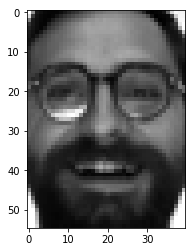

In [8]:

#----------------------------------------------
# 임의의 얼굴 하나를 출력한 다음 맞혀보는 코드 
r = random.randint(0, _num_examples -1)
print ("Label: ", sess.run(tf.argmax(test_labels[r:r+1], 1)))
print ("Prediction: ", sess.run(tf.argmax(y_conv, 1), {x:lbp_img_test[r:r+1], keep_prob:1.0}))

plt.imshow(test_images[r:r+1].reshape(55, 40), cmap='gray', interpolation='nearest')
plt.show()

